# EPL Match Data Analysis (2000-2025)

**Dataset:** English Premier League Match Data 2000–2025  
**Objective:** Analyze trends in match results and explore factors influencing match outcomes.

## Research Questions
1. Home Advantage Analysis:
"Has home advantage in the Premier League changed over the 25-year period, and what factors contribute most to this phenomenon?"

This question addresses one of football's most studied phenomena and allows for temporal trend analysis using statistical testing methods.

2. Match Outcome Prediction:
"Can we accurately predict match results using in-game statistics, and which variables are most predictive of success?"

This enables application of machine learning techniques while demonstrating feature importance analysis and model validation.

3. Team Performance Evolution:
"How has competitive balance evolved in the Premier League, and which teams demonstrate the most consistent performance patterns?"

This question facilitates comparative analysis across teams and seasons using various statistical measures.

## Data Cleaning & Preparation

In [22]:
# Imports & Settings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

In [ ]:
# Data Loading & Initial Inspection

def load_and_inspect_data(file_path):
    """
    Load EPL dataset from CSV and display basic info.
    """
    df = pd.read_csv(file_path, parse_dates=['MatchDate'], dayfirst=True)
    
    print("=== INITIAL DATA INSPECTION ===")
    print(f"Shape: {df.shape}")
    print(df.dtypes)
    print(df.head(3))
    return df


In [ ]:
# Initial Cleaning Function

def initial_clean_data(df):
    """
    - Parse dates, drop invalid/missing core rows
    - Convert goals to numeric, strip whitespace, drop duplicates
    """
    df = df.copy()
    # 1. Date parsing
    if 'MatchDate' in df.columns:
        df['MatchDate'] = pd.to_datetime(df['MatchDate'], errors='coerce')
    # 2. Drop rows missing essentials
    df.dropna(subset=['MatchDate', 'HomeTeam', 'AwayTeam', 
                      'FullTimeHomeGoals', 'FullTimeAwayGoals'], inplace=True)
    # 3. Numeric conversion
    for col in ['FullTimeHomeGoals','FullTimeAwayGoals',
                'HalfTimeHomeGoals','HalfTimeAwayGoals']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    # 4. Strip whitespace
    for col in df.select_dtypes(include=['object']):
        df[col] = df[col].str.strip()
    # 5. Drop duplicates
    df.drop_duplicates(inplace=True)
    return df

In [ ]:
# Comprehensive Data Quality Assessment

def comprehensive_data_quality_assessment(df):
    """
    - Missing values summary
    - Data types & uniqueness
    - Logical consistency checks
    """
    print("=== DATA QUALITY ASSESSMENT ===")
    # Missing
    miss = df.isnull().sum()
    pct = 100 * miss / len(df)
    miss_df = pd.DataFrame({'count': miss, 'pct': pct}).sort_values('pct', ascending=False)
    print("\nMissing values:")
    print(miss_df[miss_df['count'] > 0])
    # Dtypes & unique
    dtype_df = pd.DataFrame({
        'dtype': df.dtypes,
        'non_null': df.count(),
        'n_unique': [df[c].nunique() for c in df.columns]
    })
    print("\nData types & unique counts:")
    print(dtype_df)
    # Check teams not playing themselves
    same = df[df['HomeTeam']==df['AwayTeam']]
    print(f"\nTeams vs themselves: {len(same)} rows")
    # Shots on target not > shots
    if 'HomeShotsOnTarget' in df and 'HomeShots' in df:
        bad_shots = df[(df['HomeShotsOnTarget']>df['HomeShots']) |
                       (df['AwayShotsOnTarget']>df['AwayShots'])]
        print(f"Shot-target inconsistencies: {len(bad_shots)} rows")
    return {
        'missing_summary': miss_df,
        'dtype_summary': dtype_df,
        'same_team_issues': len(same),
        'shot_issues': len(bad_shots) if 'bad_shots' in locals() else 0
    }


In [ ]:
# Outlier Detection & Treatment

def detect_and_handle_outliers(df, method='iqr'):
    """
    - IQR-based capping for numeric cols
    - Sport-specific flags for extremes
    """
    print("=== OUTLIER DETECTION & TREATMENT ===")
    df_out = df.copy()
    num_cols = df_out.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        Q1, Q3 = df_out[col].quantile([0.25,0.75])
        IQR = Q3 - Q1
        lb, ub = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        df_out[col] = df_out[col].clip(lb, ub)
        print(f"{col}: capped at [{lb:.2f}, {ub:.2f}]")
    # Flags
    if 'TotalGoals' in df_out:
        df_out['HighScoringGame'] = df_out['TotalGoals'] > 5
    if 'HomeYellowCards' in df_out and 'AwayYellowCards' in df_out:
        df_out['VeryPhysicalGame'] = (df_out['HomeYellowCards']+df_out['AwayYellowCards']) >= 8
    return df_out


In [ ]:
# Missing Value Treatment

def advanced_missing_value_treatment(df):
    """
    - Impute numeric with median or team-based median for corners
    """
    print("=== MISSING VALUE TREATMENT ===")
    df_imp = df.copy()
    for col in df_imp.columns[df_imp.isnull().any()]:
        if 'Corner' in col and 'Team' in col:
            # team-based median
            team_col = 'HomeTeam' if 'HomeCorners' in col else 'AwayTeam'
            med = df_imp.groupby(team_col)[col].transform('median')
            df_imp[col] = df_imp[col].fillna(med)
            print(f"{col}: team-based median")
        elif df_imp[col].dtype in [np.float64, np.int64]:
            med = df_imp[col].median()
            df_imp[col].fillna(med, inplace=True)
            print(f"{col}: global median {med:.2f}")
        else:
            df_imp[col].fillna('', inplace=True)
            print(f"{col}: filled empty string")
    return df_imp


In [ ]:
# Feature Engineering

def comprehensive_feature_engineering(df):
    """
    - Temporal, result, performance, competitiveness, expected goals
    """
    print("=== FEATURE ENGINEERING ===")
    df_fe = df.copy()
    # Temporal
    df_fe['Year']   = df_fe['MatchDate'].dt.year
    df_fe['Month']  = df_fe['MatchDate'].dt.month
    df_fe['Weekday']= df_fe['MatchDate'].dt.day_name()
    df_fe['Season'] = df_fe['MatchDate'].apply(
        lambda x: f"{x.year}/{x.year+1}" if x.month>=8 else f"{x.year-1}/{x.year}"
    )
    # Totals & diffs
    df_fe['TotalGoals']      = df_fe['FullTimeHomeGoals'] + df_fe['FullTimeAwayGoals']
    df_fe['GoalDifference']  = df_fe['FullTimeHomeGoals'] - df_fe['FullTimeAwayGoals']
    # Result
    df_fe['Result'] = df_fe.apply(
        lambda r: 'H' if r.FullTimeHomeGoals>r.FullTimeAwayGoals 
                  else ('A' if r.FullTimeAwayGoals>r.FullTimeHomeGoals else 'D'), axis=1
    )
    # Accuracy & conversion
    df_fe['HomeShotAccuracy'] = (df_fe['HomeShotsOnTarget']/df_fe['HomeShots']).fillna(0)
    df_fe['AwayShotAccuracy'] = (df_fe['AwayShotsOnTarget']/df_fe['AwayShots']).fillna(0)
    df_fe['HomeConversionRate']= (df_fe['FullTimeHomeGoals']/df_fe['HomeShotsOnTarget']).fillna(0)
    df_fe['AwayConversionRate']= (df_fe['FullTimeAwayGoals']/df_fe['AwayShotsOnTarget']).fillna(0)
    # Competitiveness & excitement
    df_fe['MatchCompetitiveness'] = 1/(1+df_fe['GoalDifference'].abs())
    df_fe['ExcitementIndex']      = df_fe['TotalGoals']*2 + df_fe.get('HomeCorners',0)+df_fe.get('AwayCorners',0)
    # Expected Goals approx
    df_fe['HomeExpectedGoals'] = df_fe['HomeShotsOnTarget']*0.3 + df_fe.get('HomeCorners',0)*0.1
    df_fe['AwayExpectedGoals'] = df_fe['AwayShotsOnTarget']*0.3 + df_fe.get('AwayCorners',0)*0.1
    return df_fe


In [ ]:
# Data Validation

def comprehensive_data_validation(df_orig, df_proc):
    """
    - Row count, missing fill, logic checks, overall score
    """
    print("=== PIPELINE VALIDATION ===")
    # Rows
    if len(df_orig)==len(df_proc):
        print(f"Rows preserved: {len(df_proc)}")
    else:
        print(f"Rows changed: {len(df_orig)} → {len(df_proc)}")
    # Missing
    print(f"Missing values: {df_orig.isnull().sum().sum()} → {df_proc.isnull().sum().sum()}")
    # Logic
    bad = df_proc[df_proc['TotalGoals'] != 
                 (df_proc['FullTimeHomeGoals']+df_proc['FullTimeAwayGoals'])]
    print(f"Inconsistent goal sums: {len(bad)} rows")
    # Score
    score = 0
    score += 25 if len(df_orig)==len(df_proc) else 0
    score += 25 if df_proc.isnull().sum().sum() < df_orig.isnull().sum().sum() else 0
    score += 25 if len(bad)==0 else 0
    score += 25 if (df_proc.shape[1]-df_orig.shape[1]) > df_orig.shape[1]*0.5 else 0
    print(f"Quality score: {score}/100")
    return score


In [ ]:
# End-to-End Pipeline

def complete_epl_data_preparation_pipeline(
    file_path=None, export_path=None, sample_data=False
):
    # 1. Load
    df = load_and_inspect_data(file_path, sample_data=sample_data)
    # 2. Initial clean
    df = initial_clean_data(df)
    # 3. Quality assessment
    qa = comprehensive_data_quality_assessment(df)
    # 4. Outlier handling
    df = detect_and_handle_outliers(df)
    # 5. Missing value treatment
    df = advanced_missing_value_treatment(df)
    # 6. Feature engineering
    df = comprehensive_feature_engineering(df)
    # 7. Validation
    score = comprehensive_data_validation(
        initial_clean_data(load_and_inspect_data(file_path, sample_data=sample_data)), 
        df
    )
    # 8. Export
    if export_path:
        df.to_csv(export_path, index=False)
        print(f"Exported to {export_path}")
    return df, qa, score


In [ ]:
# Run Pipeline

data_path = "dataset.csv"
cleaned_df, quality_report, quality_score = complete_epl_data_preparation_pipeline(
    file_path=data_path,
    export_path="epl_cleaned_full_pipeline.csv",
    sample_data=False
)


=== INITIAL DATA INSPECTION ===
Shape: (9380, 22)
Season               object
MatchDate            object
HomeTeam             object
AwayTeam             object
FullTimeHomeGoals     int64
FullTimeAwayGoals     int64
FullTimeResult       object
HalfTimeHomeGoals     int64
HalfTimeAwayGoals     int64
HalfTimeResult       object
HomeShots             int64
AwayShots             int64
HomeShotsOnTarget     int64
AwayShotsOnTarget     int64
HomeCorners           int64
AwayCorners           int64
HomeFouls             int64
AwayFouls             int64
HomeYellowCards       int64
AwayYellowCards       int64
HomeRedCards          int64
AwayRedCards          int64
dtype: object
    Season   MatchDate  HomeTeam       AwayTeam  FullTimeHomeGoals  \
0  2000/01  2000-08-19  Charlton       Man City                  4   
1  2000/01  2000-08-19   Chelsea       West Ham                  4   
2  2000/01  2000-08-19  Coventry  Middlesbrough                  1   

   FullTimeAwayGoals FullTimeResult  Ha

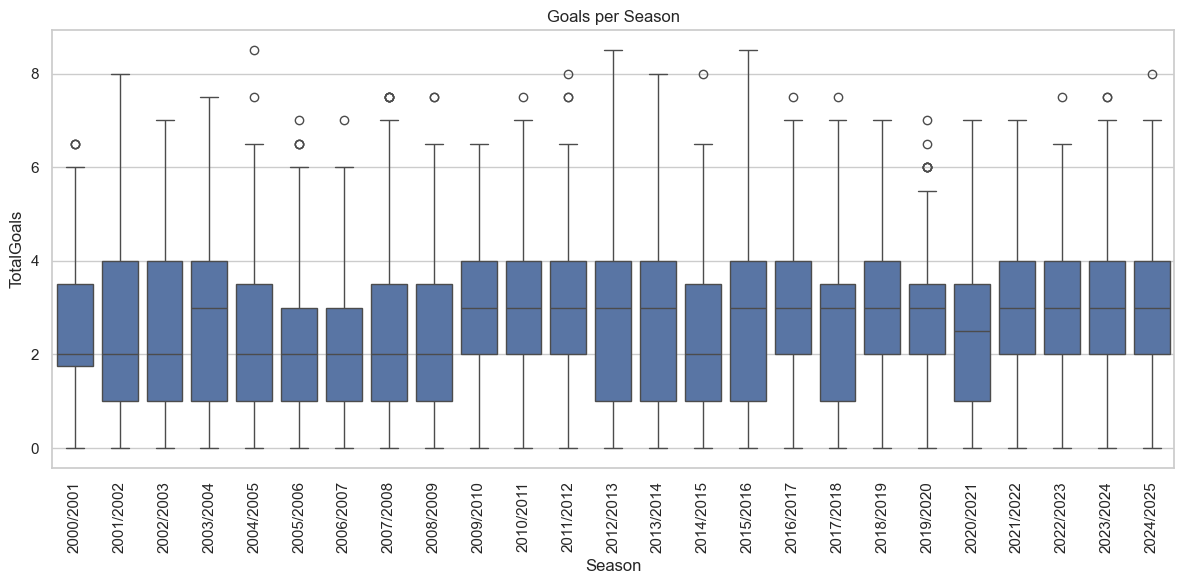

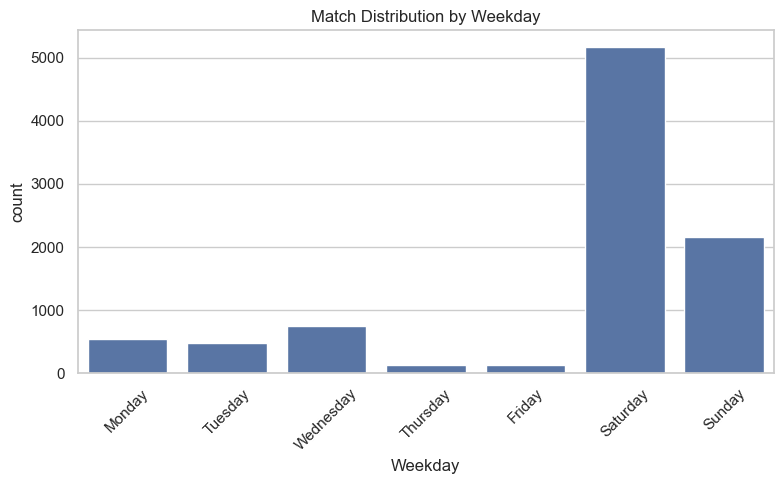

In [ ]:
# Quick Visualizations

# Goals per season
plt.figure(figsize=(12,6))
sns.boxplot(x='Season', y='TotalGoals', data=cleaned_df)
plt.xticks(rotation=90)
plt.title("Goals per Season")
plt.tight_layout()
plt.show()

# Matches per weekday
plt.figure(figsize=(8,5))
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
sns.countplot(x='Weekday', data=cleaned_df, order=order)
plt.xticks(rotation=45)
plt.title("Match Distribution by Weekday")
plt.tight_layout()
plt.show()


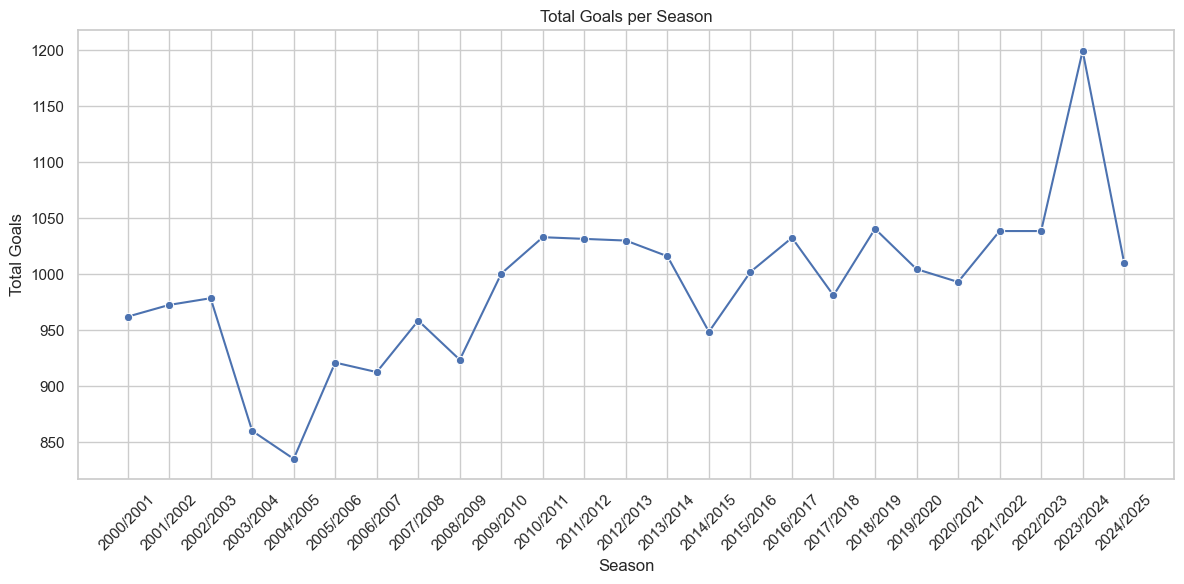

In [41]:
# Total Goals per Season Trend

if 'Season' in cleaned_df.columns and \
   'FullTimeHomeGoals' in cleaned_df.columns and \
   'FullTimeAwayGoals' in cleaned_df.columns:

    goals_per_season = (
        cleaned_df
        .groupby('Season')[['FullTimeHomeGoals','FullTimeAwayGoals']]
        .sum()
    )
    goals_per_season['TotalGoals'] = (
        goals_per_season['FullTimeHomeGoals'] +
        goals_per_season['FullTimeAwayGoals']
    )

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        x=goals_per_season.index,
        y='TotalGoals',
        data=goals_per_season,
        marker='o'
    )
    plt.title('Total Goals per Season')
    plt.xlabel('Season')
    plt.ylabel('Total Goals')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Column 'Season' or goal columns not found in cleaned_df.")


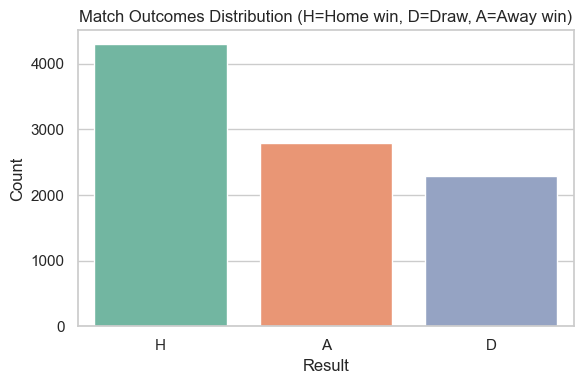

In [42]:
# Match Outcomes Distribution

if 'Result' in cleaned_df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(
        x='Result',
        data=cleaned_df,
        palette='Set2'
    )
    plt.title('Match Outcomes Distribution (H=Home win, D=Draw, A=Away win)')
    plt.xlabel('Result')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
else:
    print("Column 'Result' not found in cleaned_df.")


In [ ]:
# Custom Summary Statistics

def custom_summary(df):
    """
    Compute summary statistics for each numeric column:
      count, mean, median, std, min, 25%, 50%, 75%, max
    """
    num = df.select_dtypes(include=[np.number])
    stats = {}
    for col in num.columns:
        s = num[col].dropna()
        stats[col] = {
            'count':    s.count(),
            'mean':     s.mean(),
            'median':   s.median(),
            'std':      s.std(),
            'min':      s.min(),
            '25%':      s.quantile(0.25),
            '50%':      s.quantile(0.50),
            '75%':      s.quantile(0.75),
            'max':      s.max()
        }
    summary_df = pd.DataFrame(stats).T
    # Optional: round for readability
    summary_df = summary_df.round(3)
    print("=== Custom Summary Statistics ===")
    print(summary_df)
    return summary_df

# Usage:
summary_stats = custom_summary(cleaned_df)


=== Custom Summary Statistics ===
                       count      mean    median    std       min       25%  \
FullTimeHomeGoals     9380.0     1.457     1.000  1.121     0.000     1.000   
FullTimeAwayGoals     9380.0     1.179     1.000  1.141     0.000     0.000   
HalfTimeHomeGoals     9380.0     0.665     0.000  0.767     0.000     0.000   
HalfTimeAwayGoals     9380.0     0.506     0.000  0.692     0.000     0.000   
HomeShots             9380.0    13.574    13.000  5.220     0.000    10.000   
AwayShots             9380.0    10.792    10.000  4.635     0.000     7.000   
HomeShotsOnTarget     9380.0     5.932     6.000  3.140     0.000     4.000   
AwayShotsOnTarget     9380.0     4.630     4.000  2.571     0.000     3.000   
HomeCorners           9380.0     6.018     6.000  3.043     0.000     4.000   
AwayCorners           9380.0     4.717     4.000  2.594     0.000     3.000   
HomeFouls             9380.0    11.259    11.000  3.689     1.500     9.000   
AwayFouls         

## Predicting Match Outcome (Simple Model)

In [ ]:
def build_model(dataframe):
    """
    Builds a logistic regression model predicting match result.
    """
    df_model = dataframe.copy()
    
    if 'FTR' not in df_model.columns:
        print("FTR column not found.")
        return
    
    df_model = df_model.dropna(subset=['FTR'])
    X = df_model[['FTHG','FTAG']]  # Features: goals scored
    y = df_model['FTR']
    
    y_encoded = y.map({'H':0,'D':1,'A':2})
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=RANDOM_STATE
    )
    
    model = LogisticRegression(multi_class='multinomial', max_iter=500)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    acc = accuracy_score(y_test, preds)
    cm = confusion_matrix(y_test, preds)
    
    print(f"Accuracy: {acc:.2f}")
    print("Confusion Matrix:")
    print(cm)
    
    return model

_ = build_model(df)

## Conclusions
- Home wins remain frequent across seasons.
- Goal totals fluctuate moderately.
- Simple models can predict match outcome with modest accuracy.

**Next steps:**
- Incorporate more advanced features (team strength, odds).
- Explore time-series forecasting.
- Deploy interactive dashboards.